In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

In [55]:
N = 200

def real_model(x):
    y = (torch.randn(1, N) + 2) * x + 3 + torch.randn(1, N)
    return y

x = torch.linspace(-3, 4, N).view(-1, 1)
y = real_model(x.squeeze()).view(-1, 1)

In [66]:
class NormalModel(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.mean = None
        self.std = None

        k = 12

        self.hidden_layers = torch.nn.Sequential(
            torch.nn.Linear(1, k),
            torch.nn.ReLU()
        )
        self.mean_layer = torch.nn.Linear(k, 1)
        self.std_layer = torch.nn.Sequential(
            torch.nn.Linear(k, 1),
            torch.nn.ELU()
        )

    def forward(self, x):
        h = self.hidden_layers(x)
        self.mean = self.mean_layer(h)
        self.std = self.std_layer(h) + 1

        return self.mean, self.std
    
    def __repr__(self):
        return f'Mean: {self.mean.item():.5f} and Std: {self.std.item():.5f}'


In [67]:
def k(mean, std, x):
    return 1 / np.sqrt(2 * np.pi) * torch.exp(-((x - mean)/std) ** 2 / 2) / std

def log_k(mean, std, y):
    return -torch.log(std) - (y - mean)**2 / (2 * std**2)

In [68]:
model = NormalModel()
opt = torch.optim.Adam(model.parameters())

In [69]:
for epoch in range(5000):
    opt.zero_grad()

    if epoch % 10 == 0:
        sample = torch.randint(N, (1, 100)).squeeze()

    mean, std = model(x[sample])
    log_likelyhood = log_k(mean, std, y[sample]).sum()
    loss = -log_likelyhood
    loss.backward()
    opt.step()

    if epoch % 100 == 0:
        print(f'{epoch}:: Loss = {loss.item()}')
    


0:: Loss = 5908.8623046875
100:: Loss = 694.5260620117188
200:: Loss = 600.3509521484375
300:: Loss = 447.591552734375
400:: Loss = 347.2327575683594
500:: Loss = 320.9903869628906
600:: Loss = 302.6424865722656
700:: Loss = 206.50039672851562
800:: Loss = 202.8370819091797
900:: Loss = 159.86648559570312
1000:: Loss = 151.46926879882812
1100:: Loss = 164.55056762695312
1200:: Loss = 137.1946563720703
1300:: Loss = 139.53436279296875
1400:: Loss = 136.15322875976562
1500:: Loss = 129.7499542236328
1600:: Loss = 131.82510375976562
1700:: Loss = 129.8968505859375
1800:: Loss = 127.10769653320312
1900:: Loss = 129.9535369873047
2000:: Loss = 122.63406372070312
2100:: Loss = 125.60616302490234
2200:: Loss = 118.87802124023438
2300:: Loss = 124.900634765625
2400:: Loss = 116.79586029052734
2500:: Loss = 117.51738739013672
2600:: Loss = 122.91094970703125
2700:: Loss = 127.5123062133789
2800:: Loss = 123.34060668945312
2900:: Loss = 113.67097473144531
3000:: Loss = 130.56930541992188
3100:: 

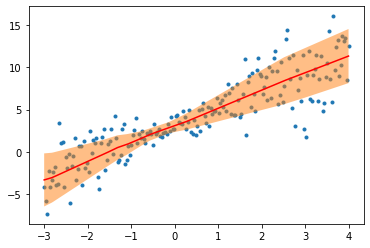

In [71]:
m, s = model(x)

plt.scatter(x, y, marker='.')
plt.plot(x, m.detach(), 'r')
plt.fill_between(x.squeeze(), (m.detach()-s.detach()).squeeze(), (m.detach()+s.detach()).squeeze(), alpha=0.5)

In [ ]:
x.size(), y.size()